# pc-gym showcase 
Author: Max Bloor (max.bloor22@imperial.ac.uk)
Notebook showcasing the current pc-gym version


## Libraries

In [29]:
from Models import Models_env #import the models 
import numpy as np 
import torch
import matplotlib.pyplot as plt 
import gymnasium as gym
import torch.nn.functional as F
import copy
from torch_pso import ParticleSwarmOptimizer

## Auxillary Functions
Includes plotting, rollout and training functions

In [2]:
#Global params
T = 26
nsteps = 100

#Simulate System
def sim(env,policy): 
    n_s = 100
    total_reward = 0
    states = np.zeros((4, n_s))
    actions = np.zeros((policy.output_sz, n_s))
    

    o, _ = env.reset()

    for i in range(n_s):
   
        obs_norm = torch.tensor([o[0],o[1]/600,o[2],o[3]/600])
        a, _states = policy.predict(obs_norm)
        
        o, r, term, trunc, info = env.step(a[0].detach().numpy() / 6*10+293)

        actions[:, i] = a.detach().numpy()
        states[:, i] = o
      
        total_reward += r
    return total_reward, states, actions

In [27]:
def plot_simulation(Ca_dat, T_dat,Tc_dat,Ca_des,con):    
    N = 100
    #Ca_des = [0.8 for i in range(int(N/2))] + [0.9 for i in range(int(N/2))]
    T_des = [330 for i in range(int(N/2))] + [320 for i in range(int(N/2))]
    t = np.linspace(0,25,N)
    plt.figure(figsize=(10, 8))

    plt.subplot(4,1,1)
    plt.plot(t, np.median(Ca_dat,axis=1), 'r-', lw=3,label = 'Ca (mol/m^3)')
    plt.gca().fill_between(t, np.min(Ca_dat,axis=1), np.max(Ca_dat,axis=1), 
                           color='r', alpha=0.2)
    plt.step(t, Ca_des, '--', lw=1.5, color='black',label = 'Setpoint')
    plt.ylabel('Ca (mol/m^3)')
    plt.xlabel('Time (min)')
    plt.legend(loc='best')
    plt.xlim(min(t), max(t))

    plt.subplot(4,1,2)
    plt.plot(t, np.median(T_dat,axis=1), 'c-', lw=3,label = 'T (K)')
    if con:
        plt.hlines(332,0,25,linestyles='dashed',label = 'Constraint')
    plt.gca().fill_between(t, np.min(T_dat,axis=1), np.max(T_dat,axis=1), 
                           color='c', alpha=0.2)
    #plt.step(t, T_des, '--', lw=1.5, color='black')
    plt.ylabel('T (K)')
    plt.xlabel('Time (min)')
    plt.legend(loc='best')
    plt.xlim(min(t), max(t))


    plt.subplot(4,1,3)
    plt.step(t, np.median(Tc_dat,axis=1), 'b--', lw=3,label = 'Cooling Temperature [K]')
    plt.ylabel('Cooling Temperature [K]')
    plt.xlabel('Time (min)')
    plt.legend(loc='best')
    plt.xlim(min(t), max(t))
    plt.tight_layout()
    plt.show()

In [4]:
class Protagonist(torch.nn.Module):
  # in current form this is a linear function (wouldn't expect great performance here)
  def __init__(self, **kwargs):
    super(Protagonist, self).__init__()
    self.dtype    = torch.float
    # Unpack the dictionary 
    self.args     = kwargs

    # Get info of machine
    self.use_cuda = torch.cuda.is_available() 
    self.device   = torch.device("cpu")

    # Define ANN topology 
    self.input_size = self.args['input_size']
    self.output_sz  = self.args['output_size']
    self.hs1        = self.input_size*2
    self.hs2        = self.output_sz*2 

    # Define layers 
    self.hidden1 = torch.nn.Linear(self.input_size, self.hs1 )
    self.hidden2 = torch.nn.Linear(self.hs1, self.hs2)
    self.output  = torch.nn.Linear(self.hs2, self.output_sz)

  def predict(self, x):
    #x = torch.tensor(x.view(1,1,-1)).float() # re-shape tensor
    x = torch.tensor(x) if isinstance(x, np.ndarray) else x
    x = x.view( 1, -1).float()
    y = F.leaky_relu(self.hidden1(x), 0.1)
    y = F.leaky_relu(self.hidden2(y), 0.1)
    y = F.relu6(self.output(y))   # range (0,6)

    return y, 0 #return an extra 0 to imitate SB3

In [21]:
def rollout_plot(policy,env,con):
    nsteps = 100
    reps = 10
    states = np.zeros((4,nsteps,reps))
    actions = np.zeros((1,nsteps,reps))
    rew = np.zeros((nsteps,reps))
    reward = []
    for r_i in range(reps):
        r,s,a = sim(env,policy)
        states[:,:,r_i] = s
        actions[:,:,r_i] = a/6*9+295
        reward.append(r)
    rew[:,r_i] = sum(reward)
    
    print("Average Reward: ",np.mean(rew))

    plot_simulation(states[0,:,:],states[1,:,:],actions[0,:,:],env.env_params['SP']['0'],con)

In [6]:
def train(policy,env):
    pso_iterations = 5


    optim = ParticleSwarmOptimizer(policy.parameters(),
                                inertial_weight=0.5,
                                num_particles=300,
                                max_param_value=5,
                                min_param_value=-5)


    for i in range(pso_iterations):
        
        def closure():
            optim.zero_grad()
            r,s,a= sim(env,policy)
      
            return -r
        
        optim.step(closure) 
        r,s,a = sim(env,policy)
        print('Iteration:',i+1,'Reward:',round(r,2))
    return policy

## 1. Reactor Case Study

Define the gym environment for a CSTR

In [7]:
#Enter required setpoints for each state. Enter None for states without setpoints.
SP = {
    '0': [0.8 for i in range(int(nsteps/2))] + [0.9 for i in range(int(nsteps/2))],
  
}

#Continuous box action space
action_space = {
    'low': np.array([297]),
    'high':np.array([303]) 
}
#Continuous box observation space
observation_space = {
    'low' : np.array([0.1,200,0.8,320]),
    'high' : np.array([4,400,0.9,330])  
}

env_params = {
    'Nx': 2, # Number of states
    'N': nsteps, # Number of time steps
    'tsim':T, # Simulation Time
    'Nu':1, # Number of control/actions
    'SP':SP, #Setpoint
    'o_space' : observation_space, #Observation space
    'a_space' : action_space, # Action space
    'dt': 1., # Time step
    'x0': np.array([0.8,330,0.8,320]), # Initial conditions (torch.tensor)
    'model': 'cstr_ode', #Select the model
    'r_scale': np.array([5,1/15]), #Scale the L1 norm used for reward (|x-x_sp|*r_scale)
}
env = Models_env(env_params)


Define the policy (neural network) structure 

In [8]:
nx = env_params['Nx']+2
nu = env_params['Nu']
hyparams = {'input_size': nx, 'output_size': nu} 
initial_policy = Protagonist(**hyparams)

Train policy

In [9]:
initial_policy = train(initial_policy,env)

Iteration: 1 Reward: -0.32
Iteration: 2 Reward: -0.32
Iteration: 3 Reward: -0.33
Iteration: 4 Reward: -0.33
Iteration: 5 Reward: -0.32


Rollout and plot the trained policy

Average Reward:  -0.3258923924174909


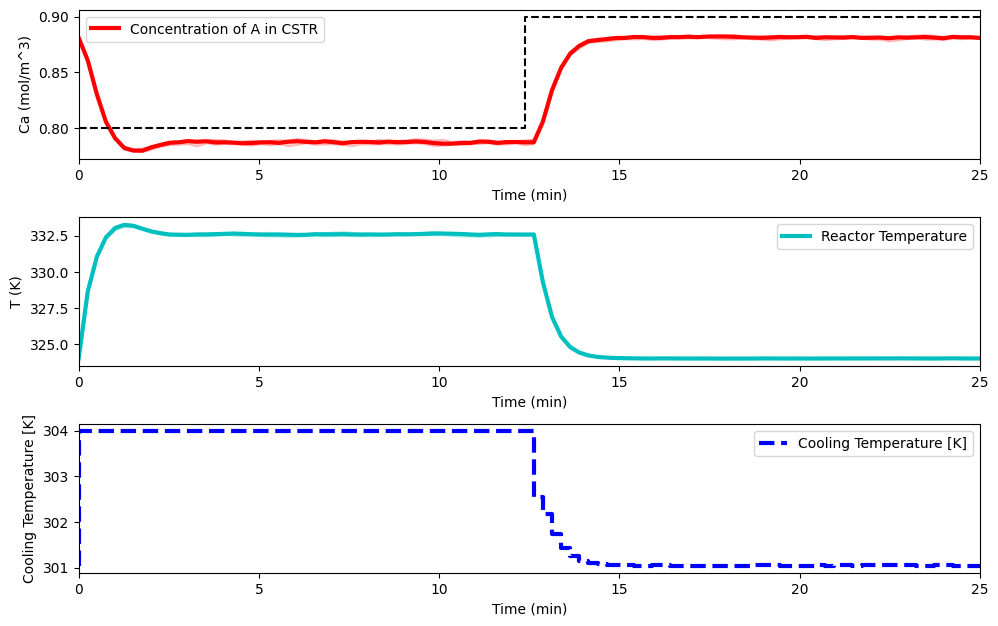

In [10]:
rollout_plot(initial_policy,env,con=False)

## 2. Disturbance Function

Step disturbance to the inlet concentration between ~6 and ~19 minutes into the episode is defined. Then the previously trained policy is rolled out with this disturbance. 

Average Reward:  -112.40170018329061


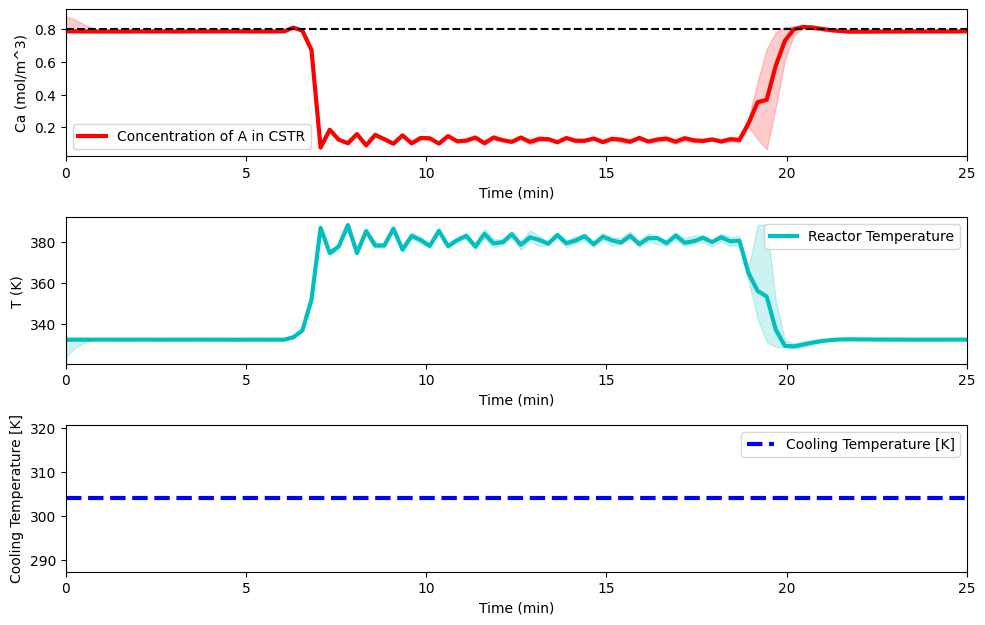

In [11]:
SP = {
    '0': [0.8 for i in range(int(nsteps))]
}
disturbance = {
    0: np.array([None for i in range(int(nsteps))]),
    1: np.array([1 for i in range(int(nsteps/4))]+[1.05 for i in range(int(nsteps/2))]+[1 for i in range(int(nsteps/4))]),
}
env_params.update({'disturbances': disturbance,
                'SP': SP})
env = Models_env(env_params)
rollout_plot(initial_policy,env,con=False)

Given the previous policy's poor performance the policy is retrained on episodes with the disturbance. 

In [12]:
dist_policy = copy.deepcopy(initial_policy)
dist_policy = train(dist_policy,env)

Iteration: 1 Reward: -0.69
Iteration: 2 Reward: -0.69
Iteration: 3 Reward: -0.69
Iteration: 4 Reward: -0.47
Iteration: 5 Reward: -0.31


Average Reward:  -0.3130251074503241


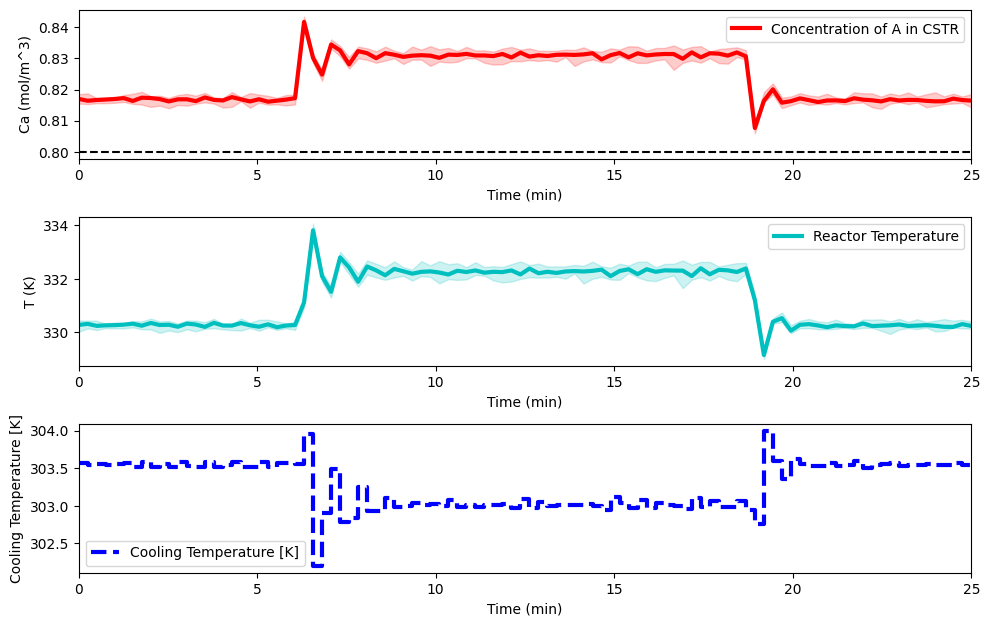

In [13]:
rollout_plot(dist_policy,env,con=False)   

## 3. Constraint Function

A constraint is shown at a reactor temperature of 332 K.

Average Reward:  -0.3134916358182739


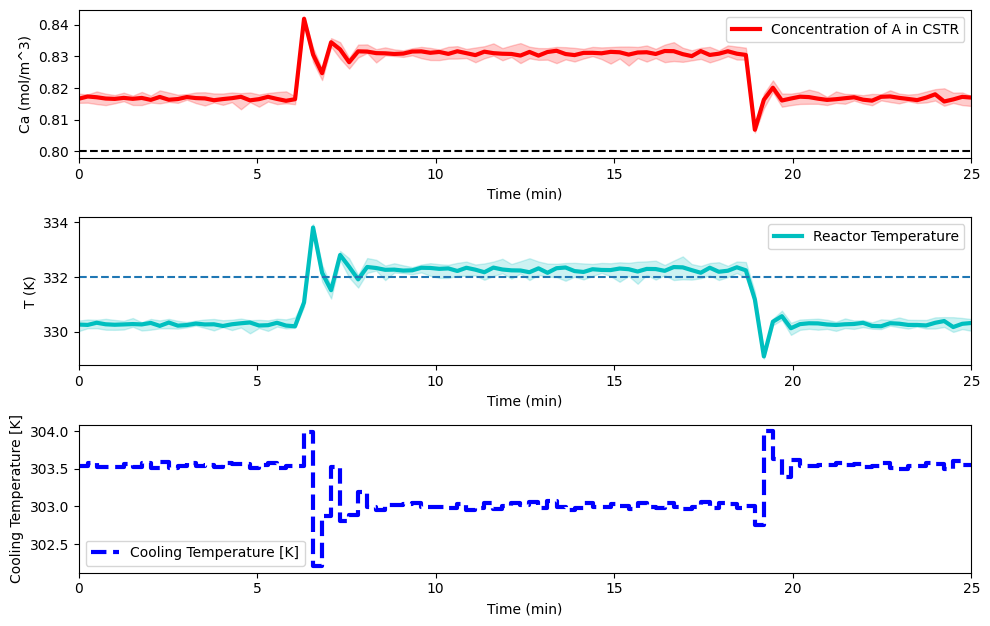

In [14]:
rollout_plot(dist_policy,env,con=True)

The constraint is defined in the environment and the reward penalty is activated to encourage policies which do not violate the constraint.

In [16]:
cons_policy = copy.deepcopy(dist_policy)
cons = {
    '0': None,
    '1' :332
}

cons_type = {
    '1':'<='
}

env_params.update({
'done_on_cons_vio':False,
'constraints': cons, 
'cons_type': cons_type,
'r_penalty': True})
env_params.get('constraints') is not None
env = Models_env(env_params)
cons_policy = train(cons_policy,env)

Iteration: 1 Reward: -1.37
Iteration: 2 Reward: -1.37
Iteration: 3 Reward: -1.37
Iteration: 4 Reward: -1.37
Iteration: 5 Reward: -1.37


Average Reward:  -1.3692991254292766


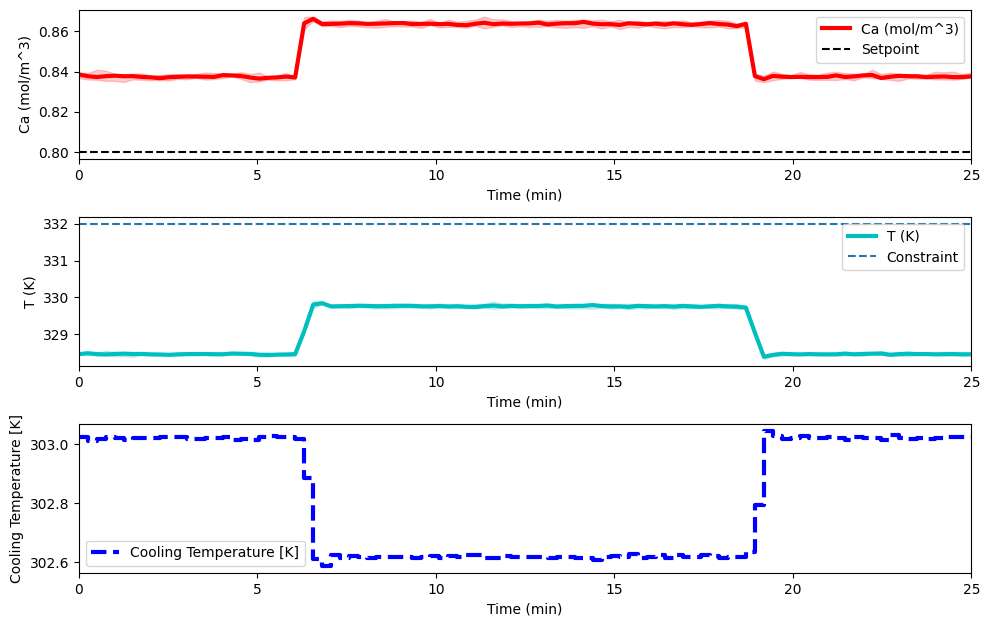

In [28]:
rollout_plot(cons_policy,env,con=True)